In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# **Introducing the Video Game Sales dataset**

In [2]:
data = pd.read_csv("Video_Games_Sales_as_at_22_Dec_2016.csv")

In [3]:
data.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


## **Data Analysis**

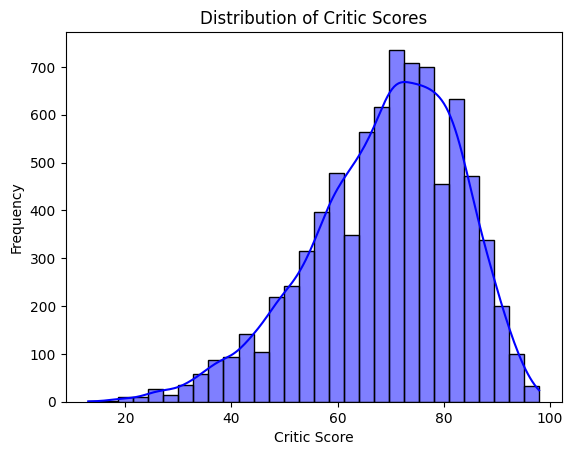

In [4]:
# Purpose: Understand the distribution of the target variable.
# This helps us know if the dataset is balanced or if transformations are needed.
# Significance: Provides insights into the overall spread of critic scores,
# which is crucial for setting a baseline expectation and understanding potential outliers.

sns.histplot(data['Critic_Score'], kde=True, bins=30, color='blue')
plt.title('Distribution of Critic Scores')
plt.xlabel('Critic Score')
plt.ylabel('Frequency')
plt.show()


 Most scores clustering between 60 and 80 and peaking around 75. Scores below 40 and above 90 are rare, indicating critics tend to give moderate to high scores.

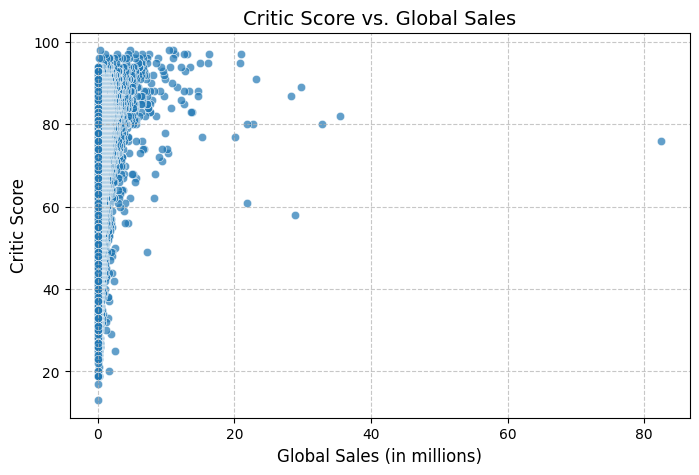

In [5]:
# Purpose: Explore whether higher critic scores correlate with greater global sales.
# Significance: Highlights the relationship between critical reception and commercial success,
# potentially revealing if sales are a strong predictor for critic scores.

plt.figure(figsize=(8, 5))
sns.scatterplot(data=data, x='Global_Sales', y='Critic_Score', alpha=0.7)
plt.title('Critic Score vs. Global Sales', fontsize=14)
plt.xlabel('Global Sales (in millions)', fontsize=12)
plt.ylabel('Critic Score', fontsize=12)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()


We can see that most games have relatively low global sales, however,
these games cover a wide range of critic scores, from poor (below 40) to excellent (close to 100).

<Axes: >

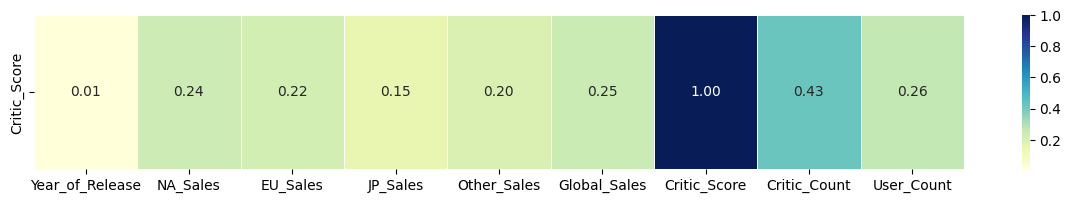

In [6]:
# Purpose: To analyze the correlation between the target feature (Critic_Score) and other numerical attributes
# in the dataset.
# Significance: This helps identify which features are most strongly related to the target and could
# be valuable for predictive modeling.

numerical_data = data.select_dtypes(include=['number'])
dtf_corr = numerical_data.corr(method="pearson").loc[["Critic_Score"]]
fig, ax = plt.subplots(figsize=(15,2))

sns.heatmap(dtf_corr, annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5,ax=ax)

The heatmap reveals a moderate positive correlation between critic scores and global sales (0.25), indicating that higher-rated games tend to perform slightly better globally. A stronger correlation exists with critic count (0.43), suggesting that games receiving more critical attention often achieve higher scores. Correlations with regional sales (NA, EU, JP) are weaker, highlighting that critic scores are not highly predictive of regional performance.

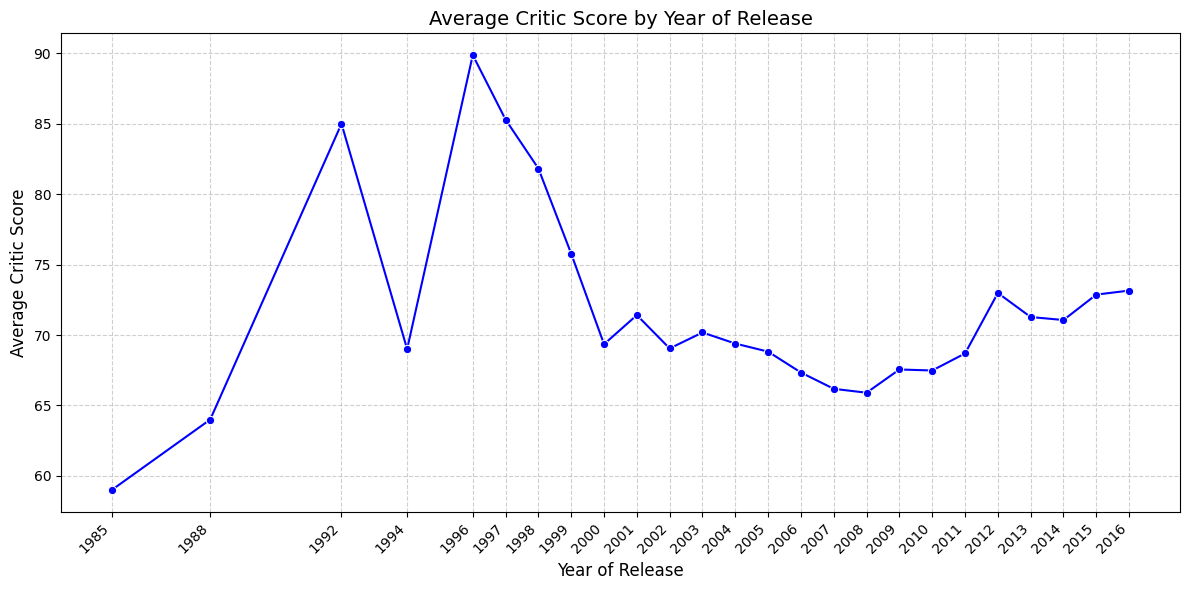

In [7]:
# Purpose: Identify which years tend to receive higher scores.
# Significance: This helps highlight trends across years, which could influence feature engineering or model performance.

data['Year_of_Release'] = pd.to_numeric(data['Year_of_Release'], errors='coerce')
data.dropna(subset=['Critic_Score', 'Year_of_Release'], inplace=True)

year_avg_scores = data.groupby('Year_of_Release')['Critic_Score'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=year_avg_scores, x='Year_of_Release', y='Critic_Score', marker='o', color='b')

plt.title('Average Critic Score by Year of Release', fontsize=14)
plt.xlabel('Year of Release', fontsize=12)
plt.ylabel('Average Critic Score', fontsize=12)
plt.xticks(ticks=year_avg_scores['Year_of_Release'], rotation=45, ha='right')
plt.grid(visible=True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


The graph shows a peak in critic scores around 1992, indicating a strong era for critically acclaimed games, followed by a decline in the early 2000s, potentially due to an influx of lower-quality games. From 2010 onwards, there’s a steady improvement, reflecting advancements in game design and technology. These trends highlight shifts in industry quality and innovation over time.

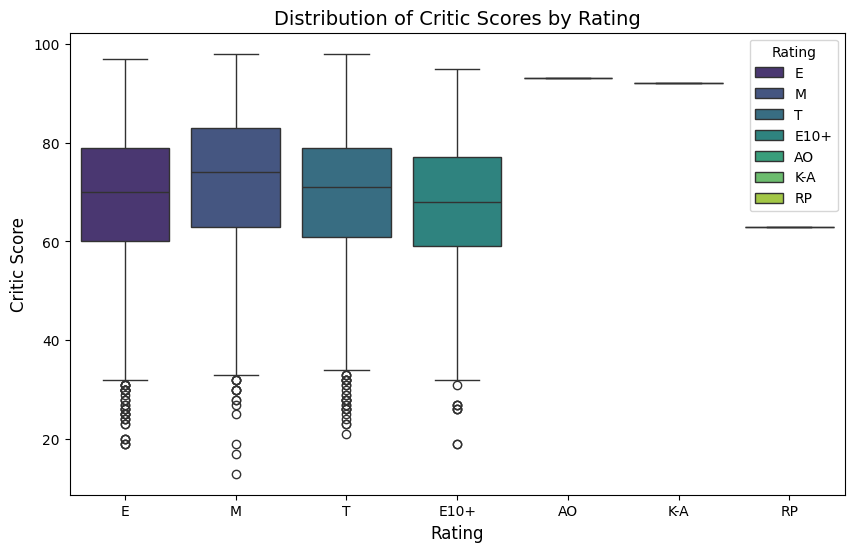

In [8]:
# - The 'Rating' column contains content ratings that categorize games based on their age suitability.
#   Common categories include:
#   - 'M' (Mature): Typically for players 17 or older, may include explicit content.
#   - 'E' (Everyone): Suitable for all ages, content is typically family-friendly.
#   - 'T' (Teen): Suitable for players aged 13 and older, may include mild language or violence.
#   - 'E10+' (Everyone 10+): Content suitable for players 10 and older, with some mild content.
#   - 'AO' (Adults Only)
#   - 'K-A' (Kids to Adults)
#   - RP (Rating Pending): This indicates a game that has been submitted for a content rating but hasn't received one yet.

# Purpose: Compare the spread and central tendency of Critic Scores across different Rating categories.
# Significance: By comparing boxplots, we can identify whether certain Rating categories tend to have higher or
# lower average Critic Scores and if there is greater variability in scores within any given category.

plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='Rating', y='Critic_Score', hue='Rating', palette='viridis', dodge=False)
plt.title('Distribution of Critic Scores by Rating', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Critic Score', fontsize=12)
plt.show()


Most ratings (E, M, T, E10+) show similar distributions of critic scores, indicating that the ESRB rating does not heavily influence critic reception.
Mature games (M) seem slightly more consistent in their critic scores, possibly reflecting higher production values or narrower target audiences.

# **Basic Model Pipeline**

In [9]:
# Identify empty cells

data.isnull().sum()
data_cleaned = data.dropna()

print(f"Rows before cleaning: {data.shape[0]}")
print(f"Rows after cleaning: {data_cleaned.shape[0]}")

Rows before cleaning: 7983
Rows after cleaning: 6825


In [10]:
# Identify categorical columns
categorical_columns = data_cleaned.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", categorical_columns)


Categorical columns: ['Name', 'Platform', 'Genre', 'Publisher', 'User_Score', 'Developer', 'Rating']


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor


# Print unique value counts for each categorical column
for col in categorical_columns:
  unique_count = data_cleaned[col].nunique()
  print(f"Unique values in {col}: {unique_count}")


X = data_cleaned.drop(columns=["Critic_Score", 'Name'])  # Drop 'Critic_Score' and 'Name' columns
y = data_cleaned["Critic_Score"]

# Label encode 'Developer' column
label_encoder = LabelEncoder()
X['Developer_encoded'] = label_encoder.fit_transform(X['Developer'])

# Drop the original 'Developer' column
X = X.drop(columns=['Developer'])

# One-hot encode the other categorical columns: 'Platform', 'Genre', 'Publisher', 'User_Score', 'Rating'
# We will use pd.get_dummies for simplicity
X = pd.get_dummies(X, columns=['Platform', 'Genre', 'Publisher', 'User_Score', 'Rating'], drop_first=True)


Unique values in Name: 4377
Unique values in Platform: 17
Unique values in Genre: 12
Unique values in Publisher: 262
Unique values in User_Score: 89
Unique values in Developer: 1289
Unique values in Rating: 7


In [12]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train the XGBoost model
model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# **Error Analysis**


In [13]:
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_percentage_error,mean_absolute_error

print("R^2 Score:","{:,.3f}".format(r2_score(y_test, y_pred)))
print("Mean Absolute Perc Error (Σ(|y - pred|/y)/n):","{:,.3f}".format(mean_absolute_percentage_error(y_test,y_pred) * 100))
print("Mean Absolute Error (Σ|y - pred|/n):", "{:,.0f}".format(mean_absolute_error(y_test, y_pred)))
print("Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)):", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))


R^2 Score: 0.600
Mean Absolute Perc Error (Σ(|y - pred|/y)/n): 11.576
Mean Absolute Error (Σ|y - pred|/n): 7
Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)): 9


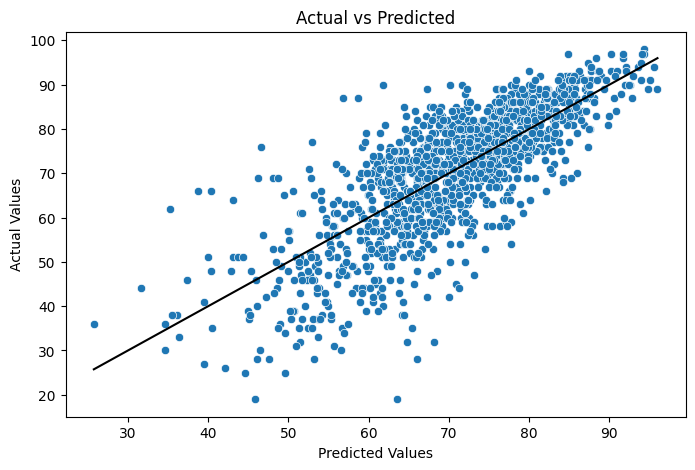

In [14]:
# Create a scatterplot for actual vs predicted values
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(x=y_pred, y=y_test, ax=ax)

sns.lineplot(x=y_pred, y=y_pred, ax=ax, color='black')

ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')
ax.set_title('Actual vs Predicted')

plt.show()

There seems to be a slight tendency for the model to underestimate values in the lower range (around 30-40).
Similarly, the model might be overestimating values in the higher range (around 80-90).

Overestimations: 632
Underestimations: 733


<Axes: >

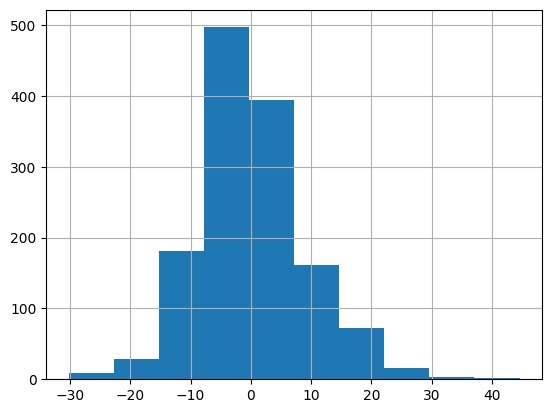

In [15]:
# Calculate prediction residuals
residuals = y_pred - y_test

overestimations = np.sum(residuals > 0)
underestimations = np.sum(residuals < 0)

print(f"Overestimations: {overestimations}")
print(f"Underestimations: {underestimations}")

residuals.hist()

From the histogram, we can see a bell-shaped distribution centered around 0, confirming that most residuals are small and relatively balanced.
The counts of overestimations (632) and underestimations (733) suggest that the model has more cases of underestimation.

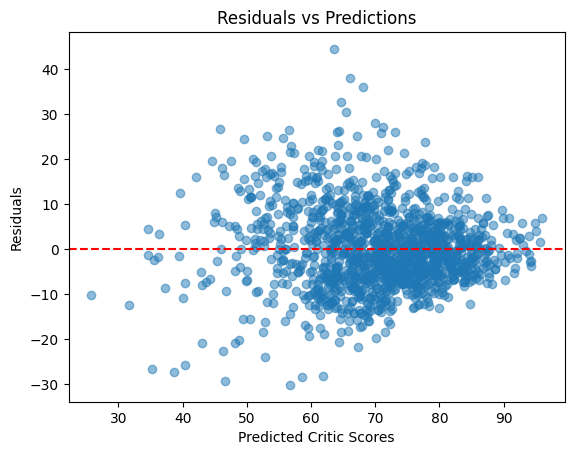

In [16]:
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Critic Scores")
plt.ylabel("Residuals")
plt.title("Residuals vs Predictions")
plt.show()


Why the Model Might Be Underestimating:
- Dataset Imbalance: If most critic scores are concentrated around the mean (60–80) and fewer games have very high scores, the model could fail to learn the patterns for those high-scoring games.
Feature Representation:

- Features like Developer, Publisher, or Genre may not sufficiently explain the high scores. Maybe, top-tier developers or publishers may not be appropriately encoded or weighted.

- Model Limitations: The model might not fully capture the complexity of the data, such as nonlinear relationships between features or interactions between features.


In [17]:
errors = np.abs(y_test - y_pred)

error_analysis = pd.DataFrame({
    "True Value": y_test,
    "Predicted Value": y_pred,
    "Absolute Error": errors,

})

worst_cases = error_analysis.sort_values(by="Absolute Error", ascending=False).head(10)
best_cases = error_analysis.sort_values(by="Absolute Error", ascending=True).head(10)

print("Worst-Performing Predictions:\n", worst_cases)
print("\nBest-Performing Predictions:\n", best_cases)

Worst-Performing Predictions:
        True Value  Predicted Value  Absolute Error
10016        19.0        63.568188       44.568188
10074        28.0        66.017075       38.017075
3197         32.0        68.184189       36.184189
3342         32.0        64.718048       32.718048
14615        35.0        65.447754       30.447754
7062         87.0        56.764317       30.235683
11299        76.0        46.571823       29.428177
5680         87.0        58.607300       28.392700
8920         90.0        61.817791       28.182209
10721        42.0        70.017853       28.017853

Best-Performing Predictions:
        True Value  Predicted Value  Absolute Error
7306         63.0        63.003830        0.003830
6750         56.0        55.994614        0.005386
2337         85.0        84.992867        0.007133
2803         80.0        80.020950        0.020950
10511        87.0        86.971649        0.028351
10653        55.0        55.034527        0.034527
8722         74.0   

The model is prone to overestimating low values and underestimating high values. This could indicate a bias toward the mean of the distribution, possibly due to underfitting or insufficient representation of extreme values in the training data.

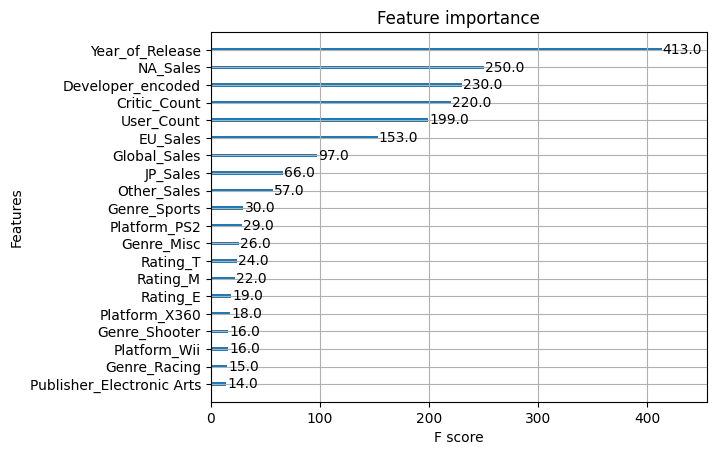

In [26]:
from xgboost import plot_importance

plot_importance(model, importance_type='weight', max_num_features=20)
plt.show()


The feature "Year_of_Release" has the highest importance score (413), far exceeding all other features. This suggests that the model heavily relies on this feature.
Over-reliance on a single feature may indicate that the model is underutilizing other features. If "Year_of_Release" correlates poorly with the target variable in unseen data, the model's performance could degrade.

Features like game genre, platform, or developer which genuinely determine critic scores—might have their importance reduced because the model is overly focused on sales and release year

# **sources**

For this project, we primarily used materials and insights from the provided notebooks, as well as assistance from AI tools, including ChatGPT and Claude. Additionally, we referred to the Kaggle notebook Video Game Sales Analysis by Krishna Bhatt for guidance and inspiration.
https://www.kaggle.com/code/krishnabhatt4/video-game-sales-analysis
